# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#TO SUPRESS WARNINGS
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import log_loss, precision_score, recall_score
from sklearn import datasets, neighbors
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
7. Finally Lemmatization as it gives better result than stemming<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [ ]:

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [ ]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
      
                    s=(wnl.lemmatize(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
              
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [ ]:
final['CleanedTextMe']=final_string 

In [ ]:

#SAVING PREPROCESSED DATA IN PICKLE FILE FOR LATER USE
final.to_pickle('amazon_food_review_after_preprocess_v2')

In [3]:
data  = pd.read_pickle("amazon_food_review_after_preprocess_v2")

In [4]:
data.sort_values('Time',inplace = True)

In [5]:
CleanedTextMe = data['CleanedTextMe']

In [6]:
polarity = data['Score']

In [7]:
#SPLITTING(TIME BASED SPLIT) TRAIN AND TEST DATA 
x_train = CleanedTextMe.iloc[:254920]
x_test = CleanedTextMe.iloc[254920:]
y_train = polarity.iloc[:254920]
y_test = polarity.iloc[254920:]

# 1. TF-IDF

In [8]:
count_vect = TfidfVectorizer(ngram_range=(1,2)) #scikit-learn countevectorizer
final_counts = count_vect.fit_transform(x_train.values)

In [9]:
#STORING VOCABULARY
cnt_vect_feat = count_vect.get_feature_names()

In [11]:
#TRAINING VECTORIZER ON TEST DATA USING VECTORS OBTAINED FROM TRAIN DATA
count_vect_test = TfidfVectorizer(ngram_range=(1,2),vocabulary=cnt_vect_feat) #scikit-learn countevectorizer
count_vect_test.fit(x_train.values)
final_counts_test = count_vect_test.transform(x_test.values)

## FInding Hyperparameters using GRIDSEARCH and RANDOMSEARCH Cross Validation

### 1. Gridsearch

In [10]:
tuned_parameters = [{'C': [10**-4, 10**-3,10**-2,10**-1, 10**0, 10**1,10**2,10**3, 10**4]}]

In [21]:
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(final_counts, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [22]:
print(model.best_estimator_)
print(model.score(final_counts_test, y_test))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9455474091770327


### 2. Randomseacrh

In [11]:
tuned_parameters_rscv = {'C': [10**-4, 10**-3,10**-2,10**-1, 10**0, 10**1,10**2,10**3, 10**4,10**5]}

In [12]:
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters_rscv, scoring = 'accuracy', cv=5)
model.fit(final_counts, y_train)

print(model.best_estimator_)
print(model.score(final_counts_test, y_test))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9455474091770327


## Observation:
#### From above cross validation we have got best result for C=1000

## Trainin Logistic regression model with optimal hyper-parameter

In [12]:
# ------------ Logistic regression with optimal LAMBDA(C)--------------###
optimal_lr = LogisticRegression(C=1000)
lp = optimal_lr.fit(final_counts, y_train)
prd = optimal_lr.predict(final_counts_test)

In [13]:
acc = accuracy_score(y_test, prd) * 100
print('\nThe accuracy of the Logistic Regression is {}' , acc)


The accuracy of the Logistic Regression is {} 94.55474091770327


## We have got accuracy of 94.55%

In [15]:
print("Classification Report")
print(classification_report(y_test,prd))

Classification Report
             precision    recall  f1-score   support

   negative       0.88      0.79      0.84     19079
   positive       0.96      0.98      0.97     90172

avg / total       0.94      0.95      0.94    109251



### CONFUSION Matrix

In [16]:
#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test,prd)
tn, fp, fn, tp = confusion_matrix(y_test,prd).ravel()

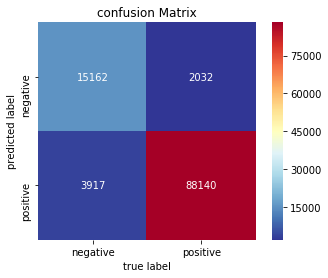

In [17]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [18]:
print("True positive rate:",(tp/(tp+fn))*100)
print("False positive rate:",(fp/(tn+fp))*100)
print("True negative rate:",(tn/(tn+fp))*100)
print("False negative rate:",(fn/(tp+fn))*100)

True positive rate: 97.74
False positive rate: 20.53
True negative rate: 79.46
False negative rate: 2.25


## Using L1 regularizer

In [19]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 
C = [10,1,0.1,0.01,0.001]
result_arr = []

In [20]:
for c in C:
    #print(c)
    tmp_result_arr = []
    clf = LogisticRegression(C=c, penalty='l1')
    clf.fit(final_counts, y_train)
    acc = accuracy_score(y_test, prd) * 100
    #print(acc)
    #print(classification_report(y_test,prd))
    w = clf.coef_
    tmp_result_arr.append(c)
    tmp_result_arr.append(acc)
    tmp_result_arr.append(np.count_nonzero(w))
    result_arr.append(tmp_result_arr)

In [21]:
result_arr_np = np.asarray(result_arr)

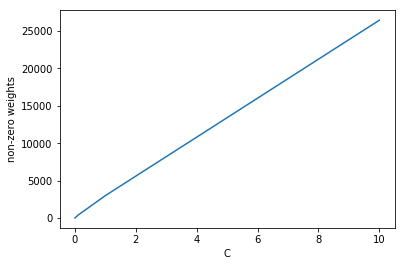

In [22]:
plt.plot(result_arr_np[:,0],result_arr_np[:,2])
plt.xlabel("C")
plt.ylabel("non-zero weights")
plt.show()

## Observation:
#### From above plot we can conclude that as C increases(lambda decreases) we get more non-zero weights. 
#### In other words as C decreases(labmda increases) feature which are less important got discarded by setting thier wights to 0.

## Feature Importance

### Imprtant feature before Mlti-Collinearity Check

Idea is we will pertubate dataset by adding small number and train model on pertbated dataset. Then we will compare wights of feature with the old weights. If weights differ significantly those features are multi-collinear and we will discard those features.

In [23]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vect, lp, 10)

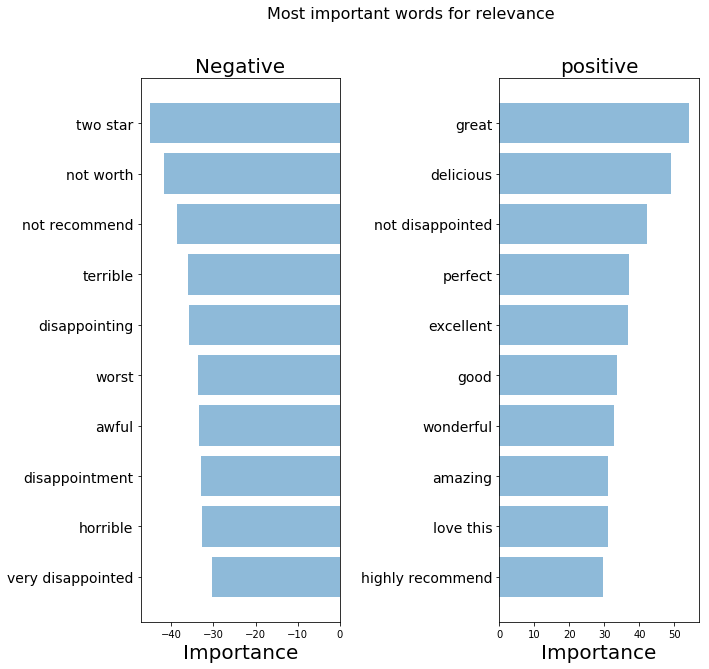

In [24]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## Multi-Collinearity Check

In [25]:
#Generating a random number from normal distribution with mean 0  and standard deviation of 0.1
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma)
s

-0.06969596045477425

In [26]:
# feature wights of old model
w_old = optimal_lr.coef_

In [27]:
final_counts_bkp = final_counts.copy()

In [28]:
final_counts_test_bkp = final_counts_test.copy()

In [29]:
# pertubating(shaking) train and test set by adding epsilon(small error) generatade from normal distributuion
final_counts[final_counts!=0]+=s
final_counts_test[final_counts_test!=0]+=s

In [30]:
# ------------ Logistic Regression with optimal Lambda--------------###
# Traing Logistic regression model for pertubated data set
optimal_lr_mod = LogisticRegression(C=1000)
lp = optimal_lr_mod.fit(final_counts, y_train)
prd = optimal_lr_mod.predict(final_counts_test)

In [31]:
# new feature waights 
w_new = optimal_lr_mod.coef_

In [32]:
# taking difference between old wiehgts and new weights
diff = []
for i in range(w_new.size):
    diff.append(w_old[:,i]-w_new[:,i])

In [33]:
diff_arr = np.asarray(diff)

In [34]:
# sorting according to diff in weights
import operator

name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
print("top 10 collinear feature:")
for i in range(10):
    print(names_diff_sorted[i])

top 10 collinear feature:
('great', array([68.77398125]))
('delicious', array([58.916949]))
('perfect', array([44.15509544]))
('not disappointed', array([40.60581069]))
('good', array([38.14334319]))
('excellent', array([38.0785097]))
('love', array([37.27932847]))
('wonderful', array([36.10479655]))
('the best', array([33.58909537]))
('favorite', array([32.79174845]))


In [35]:
#
names_diff_sorted_mod = names_diff_sorted[:20]

In [36]:
#removing collinear  feature
multicollin_indx = []
for i in range(len(names_diff_sorted_mod)):
    tu = names_diff_sorted_mod[i]
    word, z = tu
    idx = cnt_vect_feat.index(word)
    multicollin_indx.append(idx)

In [37]:
w_old_mod = np.delete(w_old,multicollin_indx,axis=1)

#### Plotting most important feature after removing multi-collinear features

In [38]:
def get_most_important_features(vectorizer, w_old_mod, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(w_old_mod.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(w_old_mod[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vect, w_old_mod, 10)

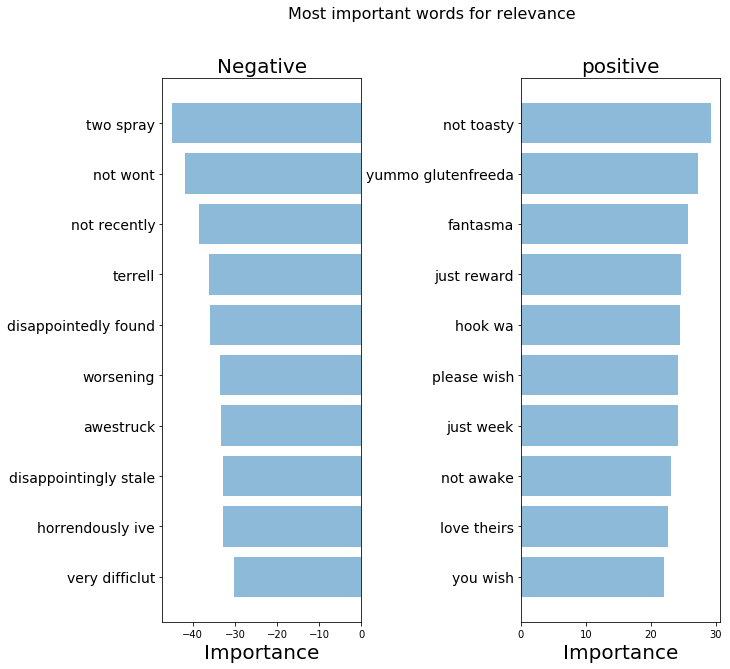

In [39]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# BAG OF WORD

In [8]:
count_vect = CountVectorizer(ngram_range=(1,2)) #scikit-learn countevectorizer
final_counts = count_vect.fit_transform(x_train.values)

#STORING VOCABULARY
cnt_vect_feat = count_vect.get_feature_names()

#TRAINING VECTORIZER ON TEST DATA USING VECTORS OBTAINED FROM TRAIN DATA
count_vect_test = CountVectorizer(ngram_range=(1,2),vocabulary=cnt_vect_feat) #scikit-learn countevectorizer
count_vect_test.fit(x_train.values)
final_counts_test = count_vect_test.transform(x_test.values)

In [9]:
final_counts = final_counts.astype(float)
final_counts_test = final_counts_test.astype(float)

In [ ]:
tuned_parameters = [{'C': [10**-4,10**-2, 10**0,10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(final_counts, y_train)

print(model.best_estimator_)
print(model.score(final_counts_test, y_test))

In [ ]:
tuned_parameters_rscv = {'C': [10**-4,10**-2, 10**0, 10**2, 10**4]}

model = RandomizedSearchCV(LogisticRegression(), tuned_parameters_rscv, scoring = 'accuracy', cv=5)
model.fit(final_counts, y_train)

print(model.best_estimator_)
print(model.score(final_counts_test, y_test))

## Trainin Logistic regression model with optimal hyper-parameter

In [11]:
# ------------ Logistic regression with optimal LAMBDA(C)--------------###
optimal_lr = LogisticRegression(C=1)
lp = optimal_lr.fit(final_counts, y_train)
prd = optimal_lr.predict(final_counts_test)

In [27]:
acc = accuracy_score(y_test, prd) * 100
print('\nThe accuracy of the Logistic Regression is {}' , acc)


The accuracy of the Logistic Regression is {} 94.34421652891048


In [28]:
print("Classification Report")
print(classification_report(y_test,prd))

Classification Report
             precision    recall  f1-score   support

   negative       0.87      0.79      0.83     19079
   positive       0.96      0.98      0.97     90172

avg / total       0.94      0.94      0.94    109251



# Confusion Matrix

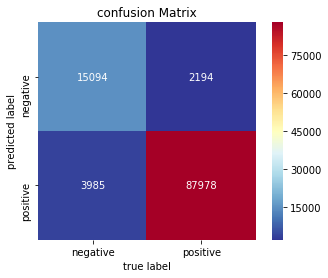

In [29]:
#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test,prd)
tn, fp, fn, tp = confusion_matrix(y_test,prd).ravel()

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [30]:
print("True positive rate:",(tp/(tp+fn))*100)
print("False positive rate:",(fp/(tn+fp))*100)
print("True negative rate:",(tn/(tn+fp))*100)
print("False negative rate:",(fn/(tp+fn))*100)

True positive rate: 97.56687219979595
False positive rate: 20.886838932858115
True negative rate: 79.11316106714187
False negative rate: 2.433127800204055


# L1 REGULARIZER

In [14]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 
C = [10,1,0.1,0.01,0.001]
result_arr = []

for c in C:
    #print(c)
    tmp_result_arr = []
    clf = LogisticRegression(C=c, penalty='l1')
    clf.fit(final_counts, y_train)
    acc = accuracy_score(y_test, prd) * 100
    #print(acc)
    #print(classification_report(y_test,prd))
    w = clf.coef_
    tmp_result_arr.append(c)
    tmp_result_arr.append(acc)
    tmp_result_arr.append(np.count_nonzero(w))
    result_arr.append(tmp_result_arr)

result_arr_np = np.asarray(result_arr)

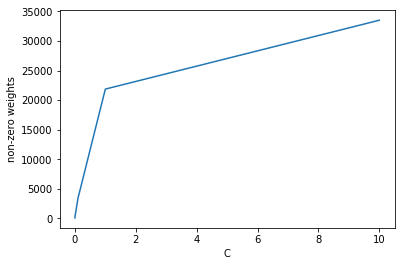

In [15]:
plt.plot(result_arr_np[:,0],result_arr_np[:,2])
plt.xlabel("C")
plt.ylabel("non-zero weights")
plt.show()

# Observation:
#### From above plot we can conclude that as C increases(lambda decreases) we get more non-zero weights. 
#### In other words as C decreases(labmda increases) feature which are less important got discarded by setting thier wights to 0.

# FEATURE IMPORTANCE

### Imprtant feature before Mlti-Collinearity Check

Idea is we will pertubate dataset by adding small number and train model on pertbated dataset. Then we will compare wights of feature with the old weights. If weights differ significantly those features are multi-collinear and we will discard those features.

In [31]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vect, lp, 10)

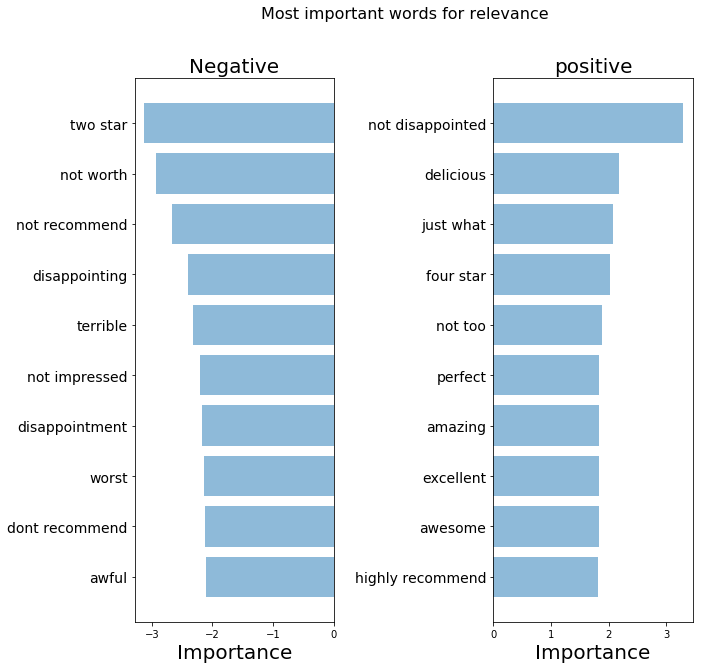

In [32]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## MUlti-Collinearity check

In [12]:
#Generating a random number from normal distribution with mean 0  and standard deviation of 0.1
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma)
s

# feature wights of old model
w_old = optimal_lr.coef_

final_counts_bkp = final_counts.copy()

final_counts_test_bkp = final_counts_test.copy()

In [13]:
# pertubating(shaking) train and test set by adding epsilon(small error) generatade from normal distributuion
final_counts[final_counts!=0]+=s
final_counts_test[final_counts_test!=0]+=s

In [14]:
# ------------ Logistic Regression with optimal Lambda--------------###
# Traing Logistic regression model for pertubated data set
optimal_lr_mod = LogisticRegression(C=1)
lp = optimal_lr_mod.fit(final_counts, y_train)
prd = optimal_lr_mod.predict(final_counts_test)

In [15]:
# new feature waights 
w_new = optimal_lr_mod.coef_

# taking difference between old wiehgts and new weights
diff = []
for i in range(w_new.size):
    diff.append(w_old[:,i]-w_new[:,i])

diff_arr = np.asarray(diff)

# sorting according to diff in weights
import operator

name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
print("top 10 collinear feature:")
for i in range(10):
    print(names_diff_sorted[i])

top 10 collinear feature:
('blue agave', array([0.13705564]))
('calorie serving', array([0.12133573]))
('not disappointed', array([0.09821287]))
('contadina', array([0.08151445]))
('delicious', array([0.0793129]))
('contadina tomato', array([0.07239313]))
('awesome', array([0.07200628]))
('excellent', array([0.07131276]))
('triglyceride', array([0.06939916]))
('hooked', array([0.06904938]))


In [16]:
#
names_diff_sorted_mod = names_diff_sorted[:20]

#removing collinear  feature
multicollin_indx = []
for i in range(len(names_diff_sorted_mod)):
    tu = names_diff_sorted_mod[i]
    word, z = tu
    idx = cnt_vect_feat.index(word)
    multicollin_indx.append(idx)

w_old_mod = np.delete(w_old,multicollin_indx,axis=1)

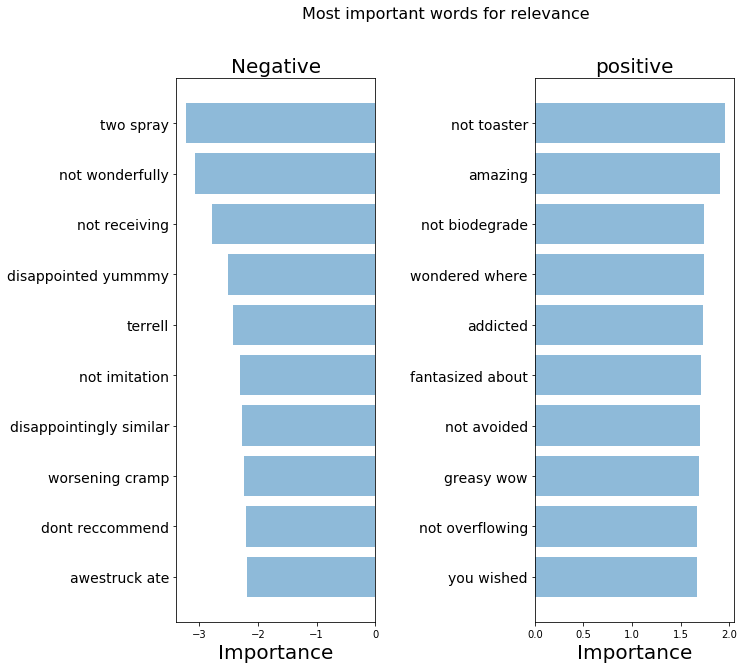

In [17]:
def get_most_important_features(vectorizer, w_old_mod, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(w_old_mod.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(w_old_mod[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vect, w_old_mod, 10)

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# AVERAGE WORD2VEC

In [11]:
tr_raw=data['Text'][:254920]
test_raw = data['Text'][254920:]

In [12]:
polarity = data['Score']

In [9]:
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [14]:
import gensim
i=0
list_of_sent_tr=[]
for sent in tr_raw.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(w.lower())
            else:
                continue 
    list_of_sent_tr.append(filtered_sentence)

In [15]:
import gensim
i=0
list_of_sent_test=[]
for sent in test_raw.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(w.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [16]:
w2v_model=gensim.models.Word2Vec(list_of_sent_tr,min_count=1,size=50, workers=4)

In [17]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

254920
50


In [18]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

109251
50


In [23]:
x_train = np.asarray(sent_vectors_tr)
x_test = np.asarray(sent_vectors_test)
y_train = polarity.iloc[:254920]
y_test = polarity.iloc[254920:]

In [27]:
optimal_lr = LogisticRegression(C=1)
lp = optimal_lr.fit(x_train, y_train)
prd = optimal_lr.predict(x_test_cleaned)


In [28]:

acc = accuracy_score(y_test_cleaned, prd) * 100
print('\nThe accuracy of the Logistic Regression is {}' , acc)


The accuracy of the Logistic Regression is {} 87.16338672768879


In [29]:
print("Classification Report")
print(classification_report(y_test_cleaned,prd))

Classification Report
             precision    recall  f1-score   support

   negative       0.72      0.43      0.54     19081
   positive       0.89      0.96      0.93     90169

avg / total       0.86      0.87      0.86    109250



Classification Report
             precision    recall  f1-score   support

   negative       0.72      0.43      0.54     19081
   positive       0.89      0.96      0.93     90169

avg / total       0.86      0.87      0.86    109250

True positive rate: 96.40342024420809
False positive rate: 56.50123159163566
True negative rate: 43.49876840836434
False negative rate: 3.5965797557919017


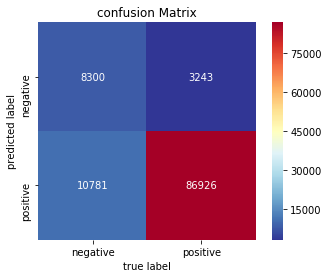

In [33]:
print("Classification Report")
print(classification_report(y_test_cleaned,prd))

#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test_cleaned,prd)
tn, fp, fn, tp = confusion_matrix(y_test_cleaned,prd).ravel()

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

print("True positive rate:",(tp/(tp+fn))*100)
print("False positive rate:",(fp/(tn+fp))*100)
print("True negative rate:",(tn/(tn+fp))*100)
print("False negative rate:",(fn/(tp+fn))*100)

# TF-IDF WORD2VEC

In [10]:
import gensim
i=0
list_of_sent=[]
for sent in data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(w.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [11]:
list_of_sent_tr = list_of_sent[:254920]
list_of_sent_test = list_of_sent[254920:]

y_train = polarity.iloc[:254920]
y_test = polarity.iloc[254920:]

xtr_df = pd.Series(list_of_sent_tr,index=y_train.index)
xtst_df = pd.Series(list_of_sent_test,index=y_test.index)

In [12]:
w2v_model=gensim.models.Word2Vec(list_of_sent_tr,min_count=1,size=50, workers=4)

In [13]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(data['Text'].values)

In [14]:
def balanced_subsample(x,y,subsample_size=0.1):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = pd.Series(ci,index=range(use_elems))
        #y_.fill(ci)

        xs.append(x_)
        ys.append(y_)
        
        

    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs,ys

In [15]:
xtrs,ytrs = balanced_subsample(xtr_df,y_train)
xtss,ytss =  balanced_subsample(xtst_df,y_test)

In [16]:
y_train = polarity.iloc[:254920]
y_test = polarity.iloc[254920:]

In [17]:
 # TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in xtrs.values: # for each review/sentence
        #print(row)
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
               # print("1. {}".format(word))
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                #print(vec * 2)
                tfidf = final_tf_idf[row, tfidf_feat.index(word)]
                #print(vec * tfidf)
                sent_vec += (vec * tfidf)
               # print(sent_vec)
                #print(tfidf)
                weight_sum += tfidf
                #print(weight_sum)
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors_tr.append(sent_vec)
        row += 1

In [18]:
np.count_nonzero(np.isnan(tfidf_sent_vectors_tr)[:,0])
removed_idx = np.unique(np.argwhere(np.isnan(tfidf_sent_vectors_tr))[:,0])
x_train_cleaned_tf = np.delete(tfidf_sent_vectors_tr,removed_idx,axis=0)
y_train_cleaned = ytrs.drop(index=removed_idx)

In [19]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in xtss.values: # for each review/sentence
        #print(row)
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
               # print("1. {}".format(word))
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                #print(vec * 2)
                tfidf = final_tf_idf[row, tfidf_feat.index(word)]
                #print(vec * tfidf)
                sent_vec += (vec * tfidf)
               # print(sent_vec)
                #print(tfidf)
                weight_sum += tfidf
                #print(weight_sum)
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors_test.append(sent_vec)
        row += 1

In [20]:
np.count_nonzero(np.isnan(tfidf_sent_vectors_test)[:,0])
removed_idx_tst = np.unique(np.argwhere(np.isnan(tfidf_sent_vectors_test))[:,0])
x_test_cleaned_tf = np.delete(tfidf_sent_vectors_test,removed_idx_tst,axis=0)
y_test_cleaned = ytss.drop(index=removed_idx_tst)

In [21]:
optimal_lr = LogisticRegression(C=1)
lp = optimal_lr.fit(x_train_cleaned_tf, y_train_cleaned)
prd = optimal_lr.predict(x_test_cleaned_tf)

In [22]:
acc = accuracy_score(y_test_cleaned, prd) * 100
print('\nThe accuracy of the Logistic Regression is {}' , acc)


The accuracy of the Logistic Regression is {} 61.5547890687185


In [23]:
print("Classification Report")
print(classification_report(y_test_cleaned,prd))

Classification Report
             precision    recall  f1-score   support

   negative       0.60      0.68      0.64      1886
   positive       0.63      0.55      0.59      1883

avg / total       0.62      0.62      0.61      3769



Classification Report
             precision    recall  f1-score   support

   negative       0.60      0.68      0.64      1886
   positive       0.63      0.55      0.59      1883

avg / total       0.62      0.62      0.61      3769

True positive rate: 54.699946893255444
False positive rate: 31.601272534464474
True negative rate: 68.39872746553553
False negative rate: 45.300053106744556


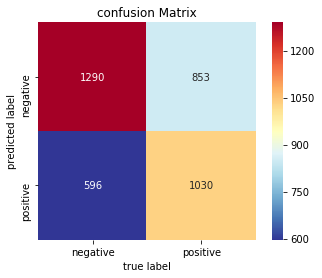

In [24]:
print("Classification Report")
print(classification_report(y_test_cleaned,prd))

#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test_cleaned,prd)
tn, fp, fn, tp = confusion_matrix(y_test_cleaned,prd).ravel()

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

print("True positive rate:",(tp/(tp+fn))*100)
print("False positive rate:",(fp/(tn+fp))*100)
print("True negative rate:",(tn/(tn+fp))*100)
print("False negative rate:",(fn/(tp+fn))*100)

# Summary

<table>
 <tr>
   <th>vectorizer</th>
   <th>Best Hyperparameter</th> 
   <th>Accuray</th>
   <th>average f1 score</th>
 </tr>
 <tr>
   <td>Bag Of Word</td>
   <td>1000</td>
   <td>94.34</td>
   <td>0.94</td>
 </tr>
 <tr>
   <td>TF-IDF</td>
   <td>1</td>
   <td>94.55</td>
   <td>0.94</td>
 </tr>
    <tr>
   <td>Average Word2Vec</td>
   <td>1</td>
   <td>87.16</td>
   <td>0.86</td>
 </tr> 
   <tr>
   <td>TF-IDF Word2vec</td>
   <td>1</td>
   <td>61.55</td>
   <td>0.61</td>
 </tr>
    
</table>

# Conclusion

<ol>
<li> From above table we can conclude that best performing model we have is TF-IDF.
</li>
<li>
because of time constraint I have trained TF-IDF weighted W2V on few sampled data points which causes detoriation in accuracy and f1-score.
</li>
</ol>